Price Prediction Based on World Events

In [3]:
import numpy as np
import pandas as pd
import scipy as sp

In [19]:
events_df = pd.read_csv('gdelt/gdelt.2011-2013.tsv.gz', index_col=False, delimiter='\t', header=0,dtype={'Date': np.str, 'Source': np.str, 'Target': np.str, 'CAMEOCode':np.str,'NumEvents':np.int32,'NumArts':np.int32, 'QuadClass':np.int8,'Goldstein':np.float32,'SourceGeoType':np.str,'SourceGeoLat':np.float32,'SourceGeoLong':np.float32,"TargetGeoType":np.str,'TargetGeoLat':np.float32,'TargetGeoLong':np.float32,'ActionGeoType':np.str,'ActionGeoLat':np.float32,'ActionGeoLong':np.float32})

In [5]:
brent_oil = pd.read_csv('gdelt/brent-oil-futures-2011-2013.tsv',index_col=False,header=0,delimiter='\t')

In [4]:
print events_df.columns
print events_df.shape

Index([u'Date', u'Source', u'Target', u'CAMEOCode', u'NumEvents', u'NumArts',
       u'QuadClass', u'Goldstein', u'SourceGeoType', u'SourceGeoLat',
       u'SourceGeoLong', u'TargetGeoType', u'TargetGeoLat', u'TargetGeoLong',
       u'ActionGeoType', u'ActionGeoLat', u'ActionGeoLong'],
      dtype='object')
(30654978, 17)


In [4]:
print events_df.Source.describe()
print events_df.Target.describe()

count     30654978
unique       16114
top            USA
freq       2270075
Name: Source, dtype: object
count     30654978
unique       25001
top            USA
freq       1735663
Name: Target, dtype: object


In [5]:
print events_df.CAMEOCode.describe()
print events_df.NumEvents.describe()
print events_df.NumArts.describe()
print events_df.QuadClass.describe()

count     30654978
unique         260
top            010
freq       2186740
Name: CAMEOCode, dtype: object
count    3.065498e+07
mean     2.152726e+00
std      3.963667e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.630000e+02
Name: NumEvents, dtype: float64
count    3.065498e+07
mean     1.860256e+01
std      1.267037e+02
min      1.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.200000e+01
max      1.108900e+05
Name: NumArts, dtype: float64
count    3.065498e+07
mean     1.840537e+00
std      1.140414e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      4.000000e+00
Name: QuadClass, dtype: float64


In [9]:
print events_df.SourceGeoType.describe()
print events_df.TargetGeoType.describe()
print events_df.ActionGeoType.describe()

count     29272709
unique           5
top              4
freq      13933944
Name: SourceGeoType, dtype: object
count     29386681
unique           5
top              4
freq      14406017
Name: TargetGeoType, dtype: object
count     30079703
unique           5
top              4
freq      14797608
Name: ActionGeoType, dtype: object


In [39]:
import matplotlib.pyplot as plt

def BarPlotWrapper(values, tick_labels, ylab):
    ind = np.arange(values.size)
    width = 1.0
    plt.bar(ind,values,width=width)
    plt.xticks(ind+width/2,tick_labels, rotation='vertical')
    plt.ylabel(ylab)
    plt.show()

#source_freq = events_df.Source.value_counts().head(50)
#BarPlotWrapper(source_freq, source_freq.index.values)

In [39]:
import matplotlib.pyplot as plt

def BarPlotWrapper(values, tick_labels):
    ind = np.arange(values.size)
    width = 1.0
    plt.bar(ind,values,width=width)
    plt.xticks(ind+width/2,tick_labels, rotation='vertical')
    plt.show()

source_freq = events_df.CAMEOCode.value_counts().head(50)
BarPlotWrapper(source_freq, source_freq.index.values)

AttributeError: 'NoneType' object has no attribute 'CAMEOCode'

In [36]:
events_df['Date_dt']=pd.to_datetime(events_df.Date.astype(np.str),format='%Y%m%d')

In [7]:
brent_oil['Date_dt']=pd.to_datetime(brent_oil.Date.astype(np.str),format='%b %d, %Y')

In [8]:
brent_oil['isIncrease']=1-brent_oil.Change.str.startswith('-').astype(np.int8)

In [14]:
from scipy import sparse

def sparse_df_to_sparse_matrix (sparse_df):
    index_list = sparse_df.index.values.tolist()
    matrix_columns = []
    sparse_matrix = None

    for column in sparse_df.columns:
        sps_series = sparse_df[column]
        sps_series.index = pd.MultiIndex.from_product([index_list, [column]])
        curr_sps_column, rows, cols = sps_series.to_coo()
        if sparse_matrix != None:
            sparse_matrix = sparse.hstack([sparse_matrix, curr_sps_column])
        else:
            sparse_matrix = curr_sps_column
        matrix_columns.extend(cols)

    return sparse_matrix, index_list, matrix_columns

def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

cameo_code_dummy = pd.get_dummies(events_df['CAMEOCode'])
#sm, il, mc = sparse_df_to_sparse_matrix(cameo_code_dummy)
#cameo_code_dummy.to_csv('cameo_code_dummy.csv.gz',compression='gzip')


In [ ]:
sm_cameo_dummy = csr_matrix((sm,il,mc),shape=cameo_code_dummy.shape)
save_sparse_csr('sm_cameo_dummy.mat',sm_cameo_dummy)

In [15]:
import time
def GetDays(x):
    return x.days
def GetBrentChangeLookup(date_str):
    date = pd.to_datetime(date_str,format='%Y%m%d')
    pos_idx = (brent_oil['Date_dt']-date).apply(GetDays)>0
    return brent_oil['isIncrease'][brent_oil['Date_dt'][pos_idx].argmin()]
def BrentChangeLookup(date):
    return look_up_table[date]

look_up_table = dict(zip(events_df['Date'].unique(),pd.Series(events_df['Date'].unique()).apply(GetBrentChangeLookup)))
BrentIncrease = events_df['Date'].apply(BrentChangeLookup)
#BrentIncrease.to_csv('brent_increase.csv')

In [16]:
events_df = None
from scipy.stats import chi2_contingency
import time
def GetChi2ContingencyP(x,y):
    return chi2_contingency([[np.sum((1-x)*(1-y)),np.sum((1-x)*y)],[np.sum(x*(1-y)),np.sum(x*y)]])[1]
p_vals = []
for column in cameo_code_dummy:
    p_vals.append(GetChi2ContingencyP(cameo_code_dummy[column],BrentIncrease))

In [17]:
event_lookup_table = {'01':'MAKE PUBLIC STATEMENT',
'010':'Make statement, not specified below',
'011':'Decline comment',
'012':'Make pessimistic comment',
'013':'Make optimistic comment',
'014':'Consider policy option',
'015':'Acknowledge or claim responsibility',
'016':'Deny responsibility',
'017':'Engage in symbolic act',
'018':'Make empathetic comment',
'019':'Express accord',
'02':'APPEAL',
'020':'Make an appeal or request, not specified below',
'021':'Appeal for material cooperation, not specified below',
'0211':'Appeal for economic cooperation',
'0212':'Appeal for military cooperation',
'0213':'Appeal for judicial cooperation',
'0214':'Appeal for intelligence',
'022':'Appeal for diplomatic cooperation (such as policy support)',
'023':'Appeal for aid, not specified below',
'0231':'Appeal for economic aid',
'0232':'Appeal for military aid',
'0233':'Appeal for humanitarian aid',
'0234':'Appeal for military protection or peacekeeping',
'024':'Appeal for political reform, not specified below',
'0241':'Appeal for change in leadership',
'0242':'Appeal for policy change',
'0243':'Appeal for rights',
'0244':'Appeal for change in institutions, regime',
'025':'Appeal to yield, not specified below',
'0251':'Appeal for easing of administrative sanctions',
'0252':'Appeal for easing of political dissent',
'0253':'Appeal for release of persons or property',
'0254':'Appeal for easing of economic sanctions, boycott, or embargo',
'0255':'Appeal for target to allow international involvement (non-mediation)',
'0256':'Appeal for de-escalation of military engagement',
'026':'Appeal to others to meet or negotiate',
'027':'Appeal to others to settle dispute',
'028':'Appeal to engage in or accept mediation',
'03':'EXPRESS INTENT TO COOPERATE',
'030':'Express intent to cooperate, not specified below',
'031':'Express intent to engage in material cooperation, not specified below',
'0311':'Express intent to cooperate economically',
'0312':'Express intent to cooperate militarily',
'0313':'Express intent to cooperate on judicial matters',
'0314':'Express intent to cooperate on intelligence',
'032':'Express intent to engage in diplomatic cooperation (such as policy support)',
'033':'Express intent to provide material aid, not specified below',
'0331':'Express intent to provide economic aid',
'0332':'Express intent to provide military aid',
'0333':'Express intent to provide humanitarian aid',
'0334':'Express intent to provide military protection or peacekeeping',
'034':'Express intent to institute political reform, not specified below',
'0341':'Express intent to change leadership',
'0342':'Express intent to change policy',
'0343':'Express intent to provide rights',
'0344':'Express intent to change institutions, regime',
'035':'Express intent to yield, not specified below',
'0351':'Express intent to ease administrative sanctions',
'0352':'Express intent to ease popular dissent',
'0353':'Express intent to release persons or property',
'0354':'Express intent to ease economic sanctions, boycott, or embargo',
'0355':'Express intent to allow international involvement (non-mediation)',
'0356':'Express intent to de-escalate military engagement',
'036':'Express intent to meet or negotiate',
'037':'Express intent to settle dispute',
'038':'Express intent to accept mediation',
'039':'Express intent to mediate',
'04':'CONSULT',
'040':'Consult, not specified below',
'041':'Discuss by telephone',
'042':'Make a visit',
'043':'Host a visit',
'044':'Meet at a ”third” location',
'045':'Mediate',
'046':'Engage in negotiation',
'05':'ENGAGE IN DIPLOMATIC COOPERATION',
'050':'Engage in diplomatic cooperation, not specified below',
'051':'Praise or endorse',
'052':'Defend verbally',
'053':'Rally support on behalf of',
'054':'Grant diplomatic recognition',
'055':'Apologize',
'056':'Forgive',
'057':'Sign formal agreement',
'06':'ENGAGE IN MATERIAL COOPERATION',
'060':'Engage in material cooperation, not specified below',
'061':'Cooperate economically',
'062':'Cooperate militarily',
'063':'Engage in judicial cooperation',
'064':'Share intelligence or information',
'07':'PROVIDE AID',
'070':'Provide aid, not specified below',
'071':'Provide economic aid',
'072':'Provide military aid',
'073':'Provide humanitarian aid',
'074':'Provide military protection or peacekeeping',
'075':'Grant asylum',
'08':'YIELD',
'080':'Yield, not specified below',
'081':'Ease administrative sanctions, not specified below',
'0811':'Ease restrictions on political freedoms',
'0812':'Ease ban on political parties or politicians',
'0813':'Ease curfew',
'0814':'Ease state of emergency or martial law',
'082':'Ease political dissent',
'083':'Accede to requests or demands for political reform, not specified below',
'0831':'Accede to demands for change in leadership',
'0832':'Accede to demands for change in policy',
'0833':'Accede to demands for rights',
'0834':'Accede to demands for change in institutions, regime',
'084':'Return, release, not specified below',
'0841':'Return, release person(s)',
'0842':'Return, release property',
'085':'Ease economic sanctions, boycott, embargo',
'086':'Allow international involvement, not specified below',
'0861':'Receive deployment of peacekeepers',
'0862':'Receive inspectors',
'0863':'Allow humanitarian access',
'087':'De-escalate military engagement',
'0871':'Declare truce, ceasefire',
'0872':'Ease military blockade',
'0873':'Demobilize armed forces',
'0874':'Retreat or surrender militarily',
'09':'INVESTIGATE',
'090':'Investigate, not specified below',
'091':'Investigate crime, corruption',
'092':'Investigate human rights abuses',
'093':'Investigate military action',
'094':'Investigate war crimes',
'10':'DEMAND',
'100':'Demand, not specified below',
'101':'Demand material cooperation, not specified below',
'1011':'Demand economic cooperation',
'1012':'Demand military cooperation',
'1013':'Demand judicial cooperation',
'1014':'Demand intelligence cooperation',
'102':'Demand diplomatic cooperation (such as policy support)',
'103':'Demand material aid, not specified below',
'1031':'Demand economic aid',
'1032':'Demand military aid',
'1033':'Demand humanitarian aid',
'1034':'Demand military protection or peacekeeping',
'104':'Demand political reform, not specified below',
'1041':'Demand change in leadership',
'1042':'Demand policy change',
'1043':'Demand rights',
'1044':'Demand change in institutions, regime',
'105':'Demand that target yields, not specified below',
'1051':'Demand easing of administrative sanctions',
'1052':'Demand easing of political dissent',
'1053':'Demand release of persons or property',
'1054':'Demand easing of economic sanctions, boycott, or embargo',
'1055':'Demand that target allows international involvement (non-mediation)',
'1056':'Demand de-escalation of military engagement',
'106':'Demand meeting, negotiation',
'107':'Demand settling of dispute',
'108':'Demand mediation',
'11':'DISAPPROVE',
'110':'Disapprove, not specified below',
'111':'Criticize or denounce',
'112':'Accuse, not specified below',
'1121':'Accuse of crime, corruption',
'1122':'Accuse of human rights abuses',
'1123':'Accuse of aggression',
'1124':'Accuse of war crimes',
'1125':'Accuse of espionage, treason',
'113':'Rally opposition against',
'114':'Complain officially',
'115':'Bring lawsuit against',
'116':'Find guilty or liable (legally)',
'12':'REJECT',
'120':'Reject, not specified below',
'121':'Reject material cooperation',
'1211':'Reject economic cooperation',
'1212':'Reject military cooperation',
'122':'Reject request or demand for material aid, not specified below',
'1221':'Reject request for economic aid',
'1222':'Reject request for military aid',
'1223':'Reject request for humanitarian aid',
'1224':'Reject request for military protection or peacekeeping',
'123':'Reject request or demand for political reform, not specified below',
'1231':'Reject request for change in leadership',
'1232':'Reject request for policy change',
'1233':'Reject request for rights',
'1234':'Reject request for change in institutions, regime',
'124':'Refuse to yield, not specified below',
'1241':'Refuse to ease administrative sanctions',
'1242':'Refuse to ease popular dissent',
'1243':'Refuse to release persons or property',
'1244':'Refuse to ease economic sanctions, boycott, or embargo',
'1245':'Refuse to allow international involvement (non mediation)',
'1246':'Refuse to de-escalate military engagement',
'125':'Reject proposal to meet, discuss, or negotiate',
'126':'Reject mediation',
'127':'Reject plan, agreement to settle dispute',
'128':'Defy norms, law',
'129':'Veto',
'13':'THREATEN',
'130':'Threaten, not specified below',
'131':'Threaten non-force, not specified below',
'1311':'Threaten to reduce or stop aid',
'1312':'Threaten with sanctions, boycott, embargo',
'1313':'Threaten to reduce or break relations',
'132':'Threaten with administrative sanctions, not specified below',
'1321':'Threaten with restrictions on political freedoms',
'1322':'Threaten to ban political parties or politicians',
'1323':'Threaten to impose curfew',
'1324':'Threaten to impose state of emergency or martial law',
'133':'Threaten with political dissent, protest',
'134':'Threaten to halt negotiations',
'135':'Threaten to halt mediation',
'136':'Threaten to halt international involvement (non-mediation)',
'137':'Threaten with repression',
'138':'Threaten with military force, not specified below',
'1381':'Threaten blockade',
'1382':'Threaten occupation',
'1383':'Threaten unconventional violence',
'1384':'Threaten conventional attack',
'1385':'Threaten attack with WMD',
'139':'Give ultimatum',
'14':'PROTEST',
'140':'Engage in political dissent, not specified below',
'141':'Demonstrate or rally, not specified below',
'1411':'Demonstrate for leadership change',
'1412':'Demonstrate for policy change',
'1413':'Demonstrate for rights',
'1414':'Demonstrate for change in institutions, regime',
'142':'Conduct hunger strike, not specified below',
'1421':'Conduct hunger strike for leadership change',
'1422':'Conduct hunger strike for policy change',
'1423':'Conduct hunger strike for rights',
'1424':'Conduct hunger strike for change in institutions, regime',
'143':'Conduct strike or boycott, not specified below',
'1431':'Conduct strike or boycott for leadership change',
'1432':'Conduct strike or boycott for policy change',
'1433':'Conduct strike or boycott for rights',
'1434':'Conduct strike or boycott for change in institutions, regime',
'144':'Obstruct passage, block, not specified below',
'1441':'Obstruct passage to demand leadership change',
'1442':'Obstruct passage to demand policy change',
'1443':'Obstruct passage to demand rights',
'1444':'Obstruct passage to demand change in institutions, regime',
'145':'Protest violently, riot, not specified below',
'1451':'Engage in violent protest for leadership change',
'1452':'Engage in violent protest for policy change',
'1453':'Engage in violent protest for rights',
'1454':'Engage in violent protest for change in institutions, regime',
'15':'EXHIBIT FORCE POSTURE',
'150':'Demonstrate military or police power, not specified below',
'151':'Increase police alert status',
'152':'Increase military alert status',
'153':'Mobilize or increase police power',
'154':'Mobilize or increase armed forces',
'155':'Mobilize or increase cyber-forces',
'16':'REDUCE RELATIONS',
'160':'Reduce relations, not specified below',
'161':'Reduce or break diplomatic relations',
'162':'Reduce or stop material aid, not specified below',
'1621':'Reduce or stop economic assistance',
'1622':'Reduce or stop military assistance',
'1623':'Reduce or stop humanitarian assistance',
'163':'Impose embargo, boycott, or sanctions',
'164':'Halt negotiations',
'165':'Halt mediation',
'166':'Expel or withdraw, not specified below',
'1661':'Expel or withdraw peacekeepers',
'1662':'Expel or withdraw inspectors, observers',
'1663':'Expel or withdraw aid agencies',
'17':'COERCE',
'170':'Coerce, not specified below',
'171':'Seize or damage property, not specified below',
'1711':'Confiscate property',
'1712':'Destroy property',
'172':'Impose administrative sanctions, not specified below',
'1721':'Impose restrictions on political freedoms',
'1722':'Ban political parties or politicians',
'1723':'Impose curfew',
'1724':'Impose state of emergency or martial law',
'173':'Arrest, detain, or charge with legal action',
'174':'Expel or deport individuals',
'175':'Use tactics of violent repression',
'176':'Attack cybernetically',
'18':'ASSAULT',
'180':'Use unconventional violence, not specified below',
'181':'Abduct, hijack, or take hostage',
'182':'Physically assault, not specified below',
'1821':'Sexually assault',
'1822':'Torture',
'1823':'Kill by physical assault',
'183':'Conduct suicide, car, or other non-military bombing, not specified below',
'1831':'Carry out suicide bombing',
'1832':'Carry out vehicular bombing',
'1833':'Carry out roadside bombing',
'1834':'Carry out location bombing',
'184':'Use as human shield',
'185':'Attempt to assassinate',
'186':'Assassinate',
'19':'FIGHT',
'190':'Use conventional military force, not specified below',
'191':'Impose blockade, restrict movement',
'192':'Occupy territory',
'193':'Fight with small arms and light weapons',
'194':'Fight with artillery and tanks',
'195':'Employ aerial weapons, not specified below',
'1951':'Employ precision-guided aerial munitions',
'1952':'Employ remotely piloted aerial munitions',
'196':'Violate ceasefire',
'20':'USE UNCONVENTIONAL MASS VIOLENCE',
'200':'Use unconventional mass violence, not specified below',
'201':'Engage in mass expulsion',
'202':'Engage in mass killings',
'203':'Engage in ethnic cleansing',
'204':'Use weapons of mass destruction, not specified below',
'2041':'Use chemical, biological, or radiological weapons',
'2042':'Detonate nuclear weapons',
'---':'None'}

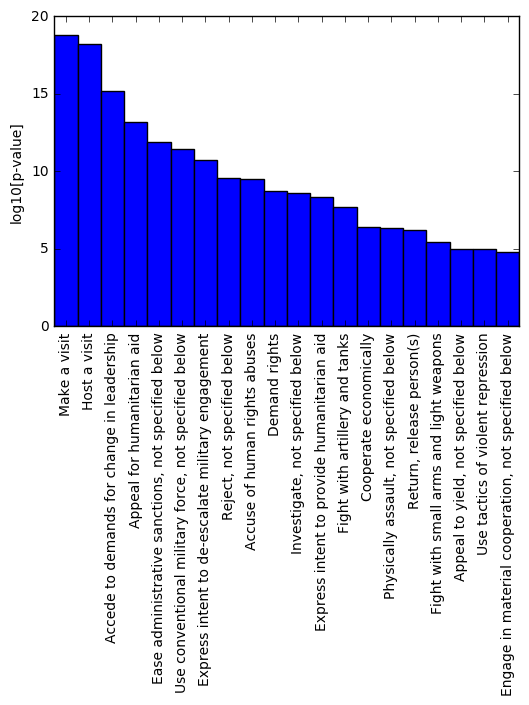

In [40]:
import matplotlib.pyplot as plt
import statsmodels.stats
def LookUpEventCode(x):
    if x in event_lookup_table:
        return event_lookup_table[x]
    else:
        return 'None'
p_val_df = pd.DataFrame({'pval': p_vals, 'labels': pd.Series(cameo_code_dummy.columns.values).apply(LookUpEventCode)})
p_val_sorted = p_val_df.sort_values(by='pval').head(20)

BarPlotWrapper(-np.log10(p_val_sorted['pval']),p_val_sorted['labels'],'log10[p-value]')

In [59]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_jobs=8,warm_start=True)
rfcl.fit(X=cameo_code_dummy.values,y=BrentIncrease)

MemoryError: 

In [31]:
brent_2011 = BrentIncrease[events_df['Date'].str.startswith('2011')]

In [38]:
random_guess_error = []
for i in range(5):
    random_guess_error.append(float(np.sum(np.abs(np.random.binomial(1,0.5,brent_2011.shape[0])-brent_2011)))/float(brent_2011.shape[0]))

mean_rg = np.mean(random_guess_error)
std_rg = np.std(random_guess_error)

rf_err = [0.51620996, 0.51647258, 0.51590074 ,0.51591663 ,0.51594681]
mean_rf = np.mean(rf_err)
std_rf = np.std(rf_err)

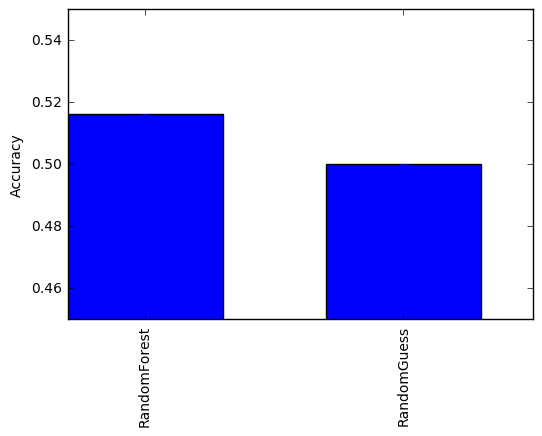

In [45]:
values = np.array([mean_rf,mean_rg])
std = np.array([std_rf,std_rg])
tick_labels = ['RandomForest','RandomGuess']
ylab = 'Accuracy'
ind = np.arange(values.size)
width = 0.6
plt.bar(ind,values,width=width,yerr=std)
plt.xticks(ind+width/2,tick_labels, rotation='vertical')
plt.ylabel(ylab)
plt.ylim(ymin=0.45)
plt.ylim(ymax=0.55)
plt.show()